In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import torch
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
import string
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from models import main_cnn


We provide the following dataset (ASSIGNMENT_2.csv):
    
| Composition title | Composition Writers | Recording Title | Recording Writes |Action |
| --- | --- |--- | --- |--- |
| Yellow submarine | Leo Ouha |Yellow submarine(remix) |Leo Ouha |Leo Ouha |ACCEPTED |
| Shape of you | Ed Sheeran| Anaconda | Mick George | Roco Selto |Leo REJECTED |


Train an ML/DL model for pair matching of compositions and recordings.
Report and evaluate the results.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
input_dataset = pd.read_csv("dataset/ASSIGNMENT_2.csv")

In [4]:
input_dataset = input_dataset.drop_duplicates().dropna()

for col in list(input_dataset.columns):
    input_dataset.loc[:, col] = input_dataset.loc[:, col].apply(lambda x: x.lower())

print(input_dataset["Action"].str.lower().unique())

['rejected' 'accepted' 'no decision' 'no_decision']


In [5]:
input_dataset.loc[input_dataset["Action"] == 'no decision', "Action"] = "no_decision"

In [6]:
input_dataset = input_dataset.loc[input_dataset["Action"]!="no_decision", :]
# we drop the rows with "no decision" label since they don't offer us any information 
# wether we have a match or not.

In [7]:
# input_dataset.dropna().drop_duplicates().shape

In [8]:
labelizer = LabelEncoder()
lb_res = labelizer.fit_transform(input_dataset.loc[:, "Action"])

input_dataset.loc[:, "Action"]= lb_res
print(Counter(input_dataset["Action"]))

Counter({0: 1485, 1: 522})


In this kind of task we have to keep stopwords and punctuation it is important on these kind of texts (just like sentiment analysis)

For starters we need to create a baseline to beat. So we could do a first run with a simple logistic regression and
an XGBoost

In [9]:
input_dataset.head(2)

,Composition Title,Composition Writers,Recording Title,Recording Writers,Recording Artist,Action
0,kokaina,yassine baybah|daniel dlouhy,kokaina,a baybah c dlouhy,miami yacine,1
1,por estar contigo,"martinez escamilla,felipe de jesus",estar contigo,martinez de ubago rodriguez alejandro,"alex, jorge y lena",1


In order to run any kind of machine learning model, we need to transform the features into tf-idf vectors.

If we had more data i would've trained embeddings from the dataset.

In [10]:
feature_cols = list(input_dataset.loc[:, input_dataset.columns!="Action"].columns)

In [11]:
input_dataset.loc[:, feature_cols].describe()

,Composition Title,Composition Writers,Recording Title,Recording Writers,Recording Artist
count,2007,2007,2007,2007,2007
unique,1802,1835,1897,1812,1660
top,flower of scotland,roy murdoch buchanan williamson,flower of scotland,traditional,various artists
freq,9,9,9,13,9


In [12]:
# we want to remove punctuation since we know that when we concatenate the dataset and make all the features into sentences
# the punctuation wont matter anymore. Since it is not important for our matching purposes

In [13]:
for col in input_dataset.columns:
    if col!="Action":
        input_dataset.loc[:, col] = input_dataset.loc[:, col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [14]:
vectorizer = TfidfVectorizer(analyzer='word')

input_dataset.loc[:, feature_cols[0]] =  input_dataset.loc[:, feature_cols[1:]].apply(lambda x: ",".join(x), axis=1)

input_dataset = pd.DataFrame(input_dataset.loc[:, feature_cols[0]])

Train test split and tf-idf vectorization 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(input_dataset, lb_res, shuffle=True, random_state=42, test_size=0.2)

X_train  = vectorizer.fit_transform(X_train.iloc[:,0])
X_test = vectorizer.transform(X_test.iloc[:, 0])

In [16]:
X_train = csr_matrix(X_train)
svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
X_train = svd.fit_transform(X_train)

X_test = csr_matrix(X_test)
svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
X_test = svd.fit_transform(X_test)

The application of SVD was important here since the sparsity of those matrices 
was substancial.

In [17]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10), scoring='f1_macro'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [18]:
def get_results(ftt, f_test_t, y_tn, y_ts, classifier):
    print("value")
    # train the model
    classifier.fit(ftt, y_tn)
    print("classifier accuracy {:.2f}%".format(classifier.score(f_test_t, y_ts) * 100))
    # even though ACCURACY IS NOT A RELIABLE METRIC HERE we have to include it in our sets of metrics.
    labels = classifier.predict(f_test_t)
    actual = y_ts
    predicted = labels
    results = confusion_matrix(actual, predicted)
    print('Confusion Matrix :')
    print(results)
    print('Accuracy Score :', accuracy_score(actual, predicted))
    print('Report : ')
    print(classification_report(actual, predicted))
    score_2 = f1_score(actual, predicted, average='macro')
    print('F-Measure: %.3f' % score_2)
    return classifier

In order to proceed with more sofisticated solutions we need to enstablish a baseline first.

The linear Regression is a good start for that purpose

Using a Linear Regression

In [19]:
cv = 3

# apply 3 fold cross validation to make sure are models are reliable (cv is set to 3 in order to be faster)

value
classifier accuracy 71.39%
Confusion Matrix :
[[285   1]
 [114   2]]
Accuracy Score : 0.7139303482587065
Report : 
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       286
           1       0.67      0.02      0.03       116

    accuracy                           0.71       402
   macro avg       0.69      0.51      0.43       402
weighted avg       0.70      0.71      0.60       402

F-Measure: 0.433


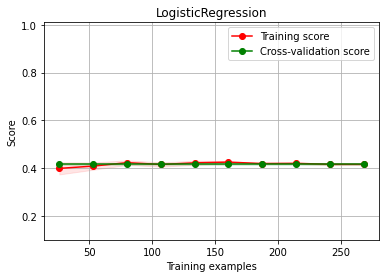

In [20]:
model = LogisticRegression(random_state=42)

model = get_results(X_train, X_test,y_train, y_test, model)
plotter = plot_learning_curve(model, "%s"%type(model).__name__, X_test, y_test, (0.1, 1.01), cv=cv, n_jobs=-1)
plotter.show()

value
classifier accuracy 71.64%
Confusion Matrix :
[[253  33]
 [ 81  35]]
Accuracy Score : 0.7164179104477612
Report : 
              precision    recall  f1-score   support

           0       0.76      0.88      0.82       286
           1       0.51      0.30      0.38       116

    accuracy                           0.72       402
   macro avg       0.64      0.59      0.60       402
weighted avg       0.69      0.72      0.69       402

F-Measure: 0.598


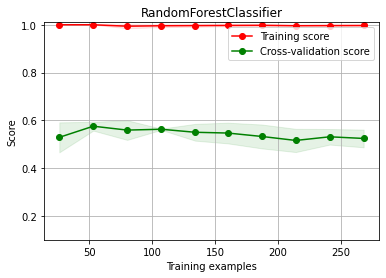

In [21]:
model = RandomForestClassifier(random_state=42)

model = get_results(X_train, X_test,y_train, y_test, model)
plotter = plot_learning_curve(model, "%s"%type(model).__name__, X_test, y_test, (0.1, 1.01), cv=cv, n_jobs=-1)
plotter.show()

Using an XGBoost classfier

value
[15:42:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
classifier accuracy 66.67%
Confusion Matrix :
[[244  42]
 [ 92  24]]
Accuracy Score : 0.6666666666666666
Report : 
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       286
           1       0.36      0.21      0.26       116

    accuracy                           0.67       402
   macro avg       0.54      0.53      0.52       402
weighted avg       0.62      0.67      0.63       402

F-Measure: 0.524


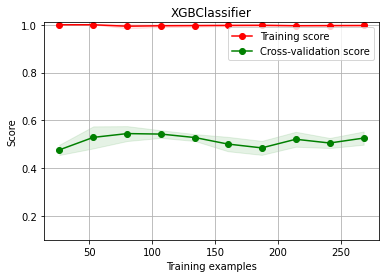

In [22]:
model = XGBClassifier(random_state=42)

model = get_results(X_train, X_test,y_train, y_test, model)
plotter = plot_learning_curve(model, "%s"%type(model).__name__, X_test, y_test, (0.1, 1.01), cv=cv, n_jobs=-1)
plotter.show()

Run a simple multilayer perceptron before we try deep neural net architecture

value
classifier accuracy 70.65%
Confusion Matrix :
[[255  31]
 [ 87  29]]
Accuracy Score : 0.7064676616915423
Report : 
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       286
           1       0.48      0.25      0.33       116

    accuracy                           0.71       402
   macro avg       0.61      0.57      0.57       402
weighted avg       0.67      0.71      0.67       402

F-Measure: 0.571


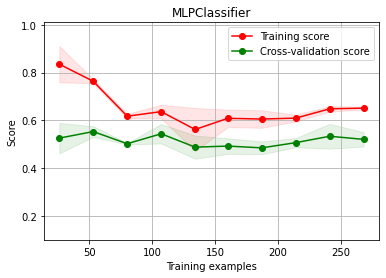

In [23]:
model = MLPClassifier(random_state=42)

get_results(X_train, X_test,y_train, y_test, model)
plotter = plot_learning_curve(model, "%s"%type(model).__name__, X_test, y_test, (0.1, 1.01), cv=cv, n_jobs=-1)
plotter.show()

Given that we achieve low scores especially on the precision of class rejected (which makes sense because so far we have majority classifiers of class accepted).

In [24]:
train_scores, eval_scores, train_losses, eval_losses = main_cnn((input_dataset, lb_res))

epoch: 0
train
loss 0.5779144483454087
score 0.4607393010310101


eval
loss 0.5379519551992417
score 0.5318302930928469
epoch: 1
train
loss 0.6027891232686884
score 0.4124433926534463


eval
loss 0.5425730466842651
score 0.5318302930928469
epoch: 2
train
loss 0.5666924715042114
score 0.4282932256605282


eval
loss 0.5397961795330047
score 0.5318302930928469
epoch: 3
train
loss 0.5644037618356592
score 0.42833495507345565


eval
loss 0.5394816160202026
score 0.5318302930928469
epoch: 4
train
loss 0.5733431384843939
score 0.42424149969314057


eval
loss 0.5405272603034973
score 0.5318302930928469
epoch: 5
train
loss 0.5758572168209973
score 0.42419599721214496


eval
loss 0.5410739481449127
score 0.5318302930928469
epoch: 6


/home/dlolis/Desktop/assignment/assignment_of/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dlolis/Desktop/assignment/assignment_of/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dlolis/Desktop/assignmen

[15:42:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/dlolis/Desktop/assignment/assignment_of/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dlolis/Desktop/assignment/assignment_of/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dlolis/Desktop/assignmen

[15:42:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/dlolis/Desktop/assignment/assignment_of/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dlolis/Desktop/assignment/assignment_of/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dlolis/Desktop/assignmen

[15:42:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

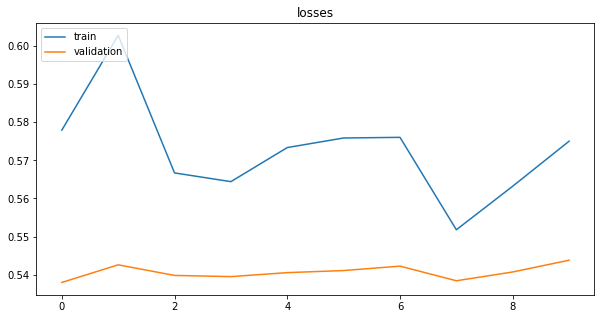

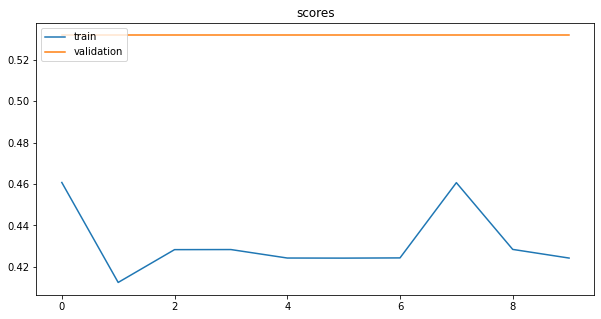

In [25]:
plt.figure(figsize=(10, 5))
plt.title("losses")
plt.plot(train_losses, label="train")
plt.plot(eval_losses, label="validation")
plt.legend(loc="upper left")

plt.show()

plt.figure(figsize=(10, 5))
plt.title("scores")
plt.plot(train_scores, label="train")
plt.plot(eval_scores, label="validation")
plt.legend(loc="upper left")

plt.show()

the best epoch of this DNN is 7 where we have the highest validation score and the lowest point on the validation loss

## Next Steps ##

We could try using our own trained word embeddings since it is rather obvious that the spasity of the tf - idf vectorization is driving our models to overfit, and word embeddings will give a much more dense represantation of our tokens.